In [56]:
# %matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from joblib import load

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier # used with Linear SVC

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# from multilabel import *

from text_cleaning_functions import text_cleaner

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Feng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
# import string

# del_punct = string.punctuation
# del_punct = del_punct.replace("-", "")  # don't remove hyphens
# rm_pattern = r"[{}]".format(del_punct)

# def clean_text(text):
#     text = text.lower()  # convert to all lower case
#     text = re.sub(r"what's", "what is ", text)
#     text = re.sub(r"\'s", " ", text)
#     text = re.sub(r"\'ve", " have ", text)
#     text = re.sub(r"can't", "can not ", text)
#     text = re.sub(r"n't", " not ", text)
#     text = re.sub(r"i'm", "i am ", text)
#     text = re.sub(r"\'re", " are ", text)
#     text = re.sub(r"\'d", " would ", text)
#     text = re.sub(r"\'ll", " will ", text)
#     text = re.sub(r"\'scuse", " excuse ", text)
#     text = re.sub(rm_pattern, "", text)  # remove punctuations
#     text = re.sub(r'[0-9]', ' ', text)  # remove digits 0-9
#     text = re.sub('\W', ' ', text)   # removes non-word character
#     text = re.sub('\s+', ' ', text)  # removes extra spaces
#     text = text.strip(' ')
#     return text
# from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.stem import WordNetLemmatizer
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# import string

# # Define stopwords to exclude
# stop = set(stopwords.words('english'))
# stop.update(("to","cc","subject","http","from","sent", "ect", "u", "fwd", "www", "com"))

# # Define punctuations to exclude and lemmatizer
# exclude = set(string.punctuation)

# # df_processed_text = pd.read_csv('processed_text.csv', usecols = ['cleaned_text'])

# wordnet_lemmatizer = WordNetLemmatizer()

# def text_lemmatizer(text):     
#     tokens = word_tokenize(text)
#     lemmatized_text = []
    
#     for token in tokens:
#         # lemmatized = wordnet_lemmatizer.lemmatize(token, pos='v')
#         lemmatized_text.append(wordnet_lemmatizer.lemmatize(token, pos='v'))
#         lemmatized_text.append(' ')
        
#     return ''.join(lemmatized_text)


# # text_cleaner includes text_lemmatizer function
# def text_cleaner(text, stop):
#     text = clean_text(text)
#     stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
#     punc_free = ''.join(i for i in stop_free if i not in exclude)
#     normalized = " ".join(wordnet_lemmatizer.lemmatize(i) for i in punc_free.split())  
    
#     return normalized


In [58]:
# len(train_text) == len(train_labels)
dataset_directory = "C:/Users/Feng/Coding projects/toxic-comments-datasets/"
train_df = pd.read_csv(dataset_directory + "train.csv.zip", usecols = ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
train_df = train_df.astype({'toxic':'int16',
                            'severe_toxic':'int16',
                            'obscene':'int16',
                            'threat':'int16',
                            'insult':'int16',
                            'identity_hate':'int16'})

train_df = train_df.dropna()  # I found 5 nan rows in cleaned_text, so I just drop those rows altogether
# print(train_df.info())


In [59]:
%%time
train_df['cleaner_text'] = train_df['comment_text'].map(lambda comments : text_cleaner(comments))

CPU times: total: 29.2 s
Wall time: 29.4 s


In [60]:
# print(train_df.info())
display(train_df[train_df.severe_toxic==1]['cleaner_text'].tail())
# print(train_df.isna().sum())

159096    filthy stinking crow back dirty crow better de...
159099          fucking pathetic moron jimbo wale rootmyass
159281           lol gay never know good feel fuck woman as
159312    walter mercado antonio quite frankly fucker co...
159400    shalom semite get fuck kill son bitch leave wi...
Name: cleaner_text, dtype: object

In [61]:
print(train_df['cleaner_text'].head())

0    explanation edits made username hardcore metal...
1    daww match background colour seemingly stuck t...
2    hey man really trying edit war guy constantly ...
3    make real suggestion improvement wondered sect...
4                        sir hero chance remember page
Name: cleaner_text, dtype: object


In [62]:
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_text = train_df['cleaner_text']
train_labels = train_df[LABELS]

# X_train_m, X_test_m, y_train_m, y_test_M = multilabel_train_test_split(train_text, train_labels, size=0.25)

X_train, X_test, y_train, y_test = train_test_split(train_text, train_labels, test_size=0.25)


In [10]:
# Define a pipeline combining a text feature extractor with multi lable classifier
countvec_NB_pipeline = Pipeline([
                ('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', MultinomialNB()) ])

tfidf_NB_pipeline = Pipeline([
                ('vectorizer', TfidfVectorizer(stop_words='english')),
                ('clf', MultinomialNB()) ])



## Precision vs Recall

Precision = TP/(TP+FP)

Recall = TP/(TP+FN)

FP = good comments wrongfully labeled toxic

FN = undetected toxic comments

Having high accuracy is misleading, since positive toxic labels are sparse. The question is, do I want high precision or high recall. Precision is a measure of true positives (correctly labeled toxic comments) relative to false positives (clean comments wrongfully labeled toxic). Recall measures true positives relative to false negatives (toxic comments that were not detected). In other words, do I want to minimize wrongfully labeled clean comments or undetected toxic comments. In my opinion, the former is preferred, since randomly deleting clean comments will upset users. Therefore, high precision is more preferred than high recall.

In [72]:
train_text_countvec = CountVectorizer().fit_transform(train_text)
train_text_tfidfvec = TfidfVectorizer().fit_transform(train_text)

## CountVec + NB

In [73]:
scores_dict = {}
print(['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])

def vectorizer_test_pipeline(vectorized_text, clf):
    '''
    vectorized_text: sparse matrix of comments from CountVectorizer of TfidfVectorizer
    clf: a classifier for supervised learning
    '''
    
    X_train_vec, X_test_vec, y_train, y_test = train_test_split(vectorized_text, train_labels, test_size=0.25)
    
    for label in LABELS:
        print('... Processing {}'.format(label))
        
        clf.fit(X_train_vec, y_train[label])

        pred = clf.predict(X_test_vec)
        test = y_test[label]
        
        scores = [accuracy_score(test, pred), balanced_accuracy_score(test,pred), precision_score(test, pred), recall_score(test, pred), f1_score(test, pred) ] 
        scores_dict[label] = scores
        # scores = np.round(scores, decimals = 2)
        
        print(np.round(scores, decimals = 2))

    pred_scores = pd.DataFrame(scores_dict, index=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])
    display(np.round(pred_scores.T, decimals=2))
    
    return(pred_scores.T)
    

['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']


In [79]:
count_vec_scores = vectorizer_test_pipeline(train_text_countvec, LogisticRegression())

... Processing toxic


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.96 0.83 0.85 0.67 0.75]
... Processing severe_toxic


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.99 0.62 0.52 0.25 0.34]
... Processing obscene


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.98 0.84 0.85 0.69 0.76]
... Processing threat


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[1.   0.6  0.31 0.21 0.25]
... Processing insult


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.97 0.75 0.75 0.52 0.61]
... Processing identity_hate
[0.99 0.6  0.49 0.2  0.28]


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,accuracy,balanced_accuracy,precision,recall,f1
toxic,0.96,0.83,0.85,0.67,0.75
severe_toxic,0.99,0.62,0.52,0.25,0.34
obscene,0.98,0.84,0.85,0.69,0.76
threat,1.00,0.60,0.31,0.21,0.25
insult,0.97,0.75,0.75,0.52,0.61
identity_hate,0.99,0.60,0.49,0.20,0.28


In [81]:
tfidf_vec_scores = vectorizer_test_pipeline(train_text_tfidfvec, LogisticRegression())

... Processing toxic
[0.96 0.8  0.93 0.6  0.73]
... Processing severe_toxic
[0.99 0.61 0.57 0.22 0.32]
... Processing obscene
[0.98 0.81 0.91 0.62 0.73]
... Processing threat
[1.   0.55 0.73 0.09 0.17]
... Processing insult
[0.97 0.75 0.81 0.5  0.62]
... Processing identity_hate
[0.99 0.57 0.64 0.14 0.23]


,accuracy,balanced_accuracy,precision,recall,f1
toxic,0.96,0.80,0.93,0.60,0.73
severe_toxic,0.99,0.61,0.57,0.22,0.32
obscene,0.98,0.81,0.91,0.62,0.73
threat,1.00,0.55,0.73,0.09,0.17
insult,0.97,0.75,0.81,0.50,0.62
identity_hate,0.99,0.57,0.64,0.14,0.23


## Comparing Tfidf to BoW
Based on metrics of recall and f1, **BoW** is the clear winner.

In [88]:
print(train_text_countvec.shape)
print(train_text_tfidfvec.shape)
display(round(count_vec_scores.mean(),2))
display(round(tfidf_vec_scores.mean(),2))

(159571, 198129)
(159571, 198129)


accuracy             0.98
balanced_accuracy    0.71
precision            0.63
recall               0.42
f1                   0.50
dtype: float64

accuracy             0.98
balanced_accuracy    0.68
precision            0.76
recall               0.36
f1                   0.47
dtype: float64

In [64]:

# scores_dict = {}
# print(['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])
# X_train_vec = TfidfVectorizer().fit_transform(X_train)
# X_test_vec = TfidfVectorizer().fit_transform(X_test)
# clf = MultinomialNB()
# for label in LABELS:
#     print('... Processing {}'.format(label))
#     clf.fit(X_train_vec, y_train[label])
#     # countvec_NB_pipeline.fit(X_train.iloc[0:10000], y_train[label].iloc[0:10000]) # train with a slice 
#     # tfidf_NB_pipeline.fit(X_train, y_train[label])  # train with whole dataset

#     # compute the testing accuracy
#     # pred = tfidf_NB_pipeline.predict(X_test)
#     pred = clf.predict(X_test_vec)
#     test = y_test[label]
    
#     scores = [accuracy_score(test, pred), balanced_accuracy_score(test, pred), precision_score(test, pred), recall_score(test, pred), f1_score(test, pred) ] 
#     scores_dict[label] = scores
    
#     print(np.round(scores, decimals = 2))

# scores_tfidf_NB = pd.DataFrame(scores_dict, index=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']).T
# print(np.round(scores_tfidf_NB, decimals=2))

['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
... Processing toxic


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.9 0.5 0.  0.  0. ]
... Processing severe_toxic


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.99 0.5  0.   0.   0.  ]
... Processing obscene


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.95 0.5  0.   0.   0.  ]
... Processing threat


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1.  0.5 0.  0.  0. ]
... Processing insult


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.95 0.5  0.   0.   0.  ]
... Processing identity_hate
[0.99 0.5  0.   0.   0.  ]
               accuracy  balanced_accuracy  precision  recall   f1
toxic              0.90                0.5        0.0     0.0  0.0
severe_toxic       0.99                0.5        0.0     0.0  0.0
obscene            0.95                0.5        0.0     0.0  0.0
threat             1.00                0.5        0.0     0.0  0.0
insult             0.95                0.5        0.0     0.0  0.0
identity_hate      0.99                0.5        0.0     0.0  0.0


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
# scores_count_NB = pred_scores.T
# print('--------CountVectorizer scores----------')
# display(np.round(scores_count_NB, 2))
# print('-- CountVectorizer mean scores --')
# display(np.round(scores_count_NB.mean(), 3))
# print('--------TfidfVectorizer scores----------')
# display(np.round(scores_tfidf_NB, 2))
# print('-- TfidfVectorizer mean scores --')
# display(np.round(scores_tfidf_NB.mean(), 3))


--------CountVectorizer scores----------


,accuracy,balanced_accuracy,precision,recall,f1
toxic,0.91,0.52,0.71,0.04,0.07
severe_toxic,0.99,0.57,0.26,0.14,0.18
obscene,0.95,0.53,0.61,0.06,0.11
threat,0.99,0.54,0.05,0.09,0.07
insult,0.95,0.53,0.58,0.06,0.11
identity_hate,0.99,0.60,0.36,0.20,0.26


-- CountVectorizer mean scores --


accuracy             0.963
balanced_accuracy    0.549
precision            0.430
recall               0.100
f1                   0.135
dtype: float64

--------TfidfVectorizer scores----------


,accuracy,balanced_accuracy,precision,recall,f1
toxic,0.90,0.5,0.0,0.0,0.0
severe_toxic,0.99,0.5,0.0,0.0,0.0
obscene,0.95,0.5,0.0,0.0,0.0
threat,1.00,0.5,0.0,0.0,0.0
insult,0.95,0.5,0.0,0.0,0.0
identity_hate,0.99,0.5,0.0,0.0,0.0


-- TfidfVectorizer mean scores --


accuracy             0.964
balanced_accuracy    0.500
precision            0.000
recall               0.000
f1                   0.000
dtype: float64

In [137]:
# Define a pipeline combining a text feature extractor with multi lable classifier
OVR_NB_pipeline = Pipeline([
                # ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

OVR_NB_pipeline.fit(X_train, y_train)


Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', OneVsRestClassifier(estimator=MultinomialNB()))])

In [23]:
y_pred = OVR_NB_pipeline.predict(X_test)
y_proba = OVR_NB_pipeline.predict_proba(X_test)

print(LABELS)
multi_cm = multilabel_confusion_matrix(y_test, y_pred, samplewise=False)

for i in range(multi_cm.shape[0]):
    #[[TN, FP],
    # [FN, TP]]
    print(LABELS[i])
    print(multi_cm[i,:,:])
 

NameError: name 'OVR_NB_pipeline' is not defined

In [24]:
def metrics_table(test, pred, proba):
    
    hamming_losses = []
    acc_scores = []
    bal_acc_scores = []
    roc_auc_scores = []
    scores_multi = {}

    for i, label in enumerate(LABELS):
        
        acc = accuracy_score(test[:,i], pred[:,i])
        acc_scores.append(acc)
        
        bal_acc = balanced_accuracy_score(test[:,i], pred[:,i])
        bal_acc_scores.append(bal_acc)
        
        # hamming = hamming_loss(test[:,i], pred[:,i])
        # hamming_losses.append(hamming)

        roc_auc = roc_auc_score(test[:,i], proba[:,i])
        roc_auc_scores.append(roc_auc)
        
    scores_multi['accuracy']= acc_scores
    scores_multi['balanced_accuracy']= bal_acc_scores
    scores_multi['roc_auc_score'] = roc_auc_scores
    # scores_multi['hamming_loss']= hamming_losses  # hamming_loss isn't that useful
    
    scores_multi['precision'] = precision_score(test, pred, average=None) 
    scores_multi['recall'] = recall_score(test, pred, average=None) 
    scores_multi['f1'] = f1_score(test, pred, average=None) 

    scores_multi_df = pd.DataFrame(scores_multi, index = LABELS)
    print(np.round(scores_multi_df,3))
    
    return scores_multi_df

In [22]:
test = y_test.values  # y_test is a DataFrame, so it must be converted into nd.array
pred = y_pred  # binary predictions for each label
proba = y_proba # probabilities for each prediction

scores_multi_df = metrics_table(test, pred, proba)

NameError: name 'y_pred' is not defined

In [48]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

param_grid = {'alpha': np.arange(0.0001, 1, 5)}

# Define a pipeline combining a text feature extractor with multi lable classifier

X_train, X_test, y_train, y_test = train_test_split(train_text, train_labels, test_size=0.25)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [239]:
print(y_train.value_counts(normalize=True).head())
print(y_test.value_counts(normalize=True).head())

toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0                0.898432
1      0             0        0       0       0                0.035380
                     1        0       1       0                0.023639
                                      0       0                0.011130
                     0        0       1       0                0.007621
dtype: float64
toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0                0.897972
1      0             0        0       0       0                0.035898
                     1        0       1       0                0.024341
                                      0       0                0.010679
                     0        0       1       0                0.007596
dtype: float64


## Optimize model

In [217]:

for alpha_index in np.array([0.1, 0.15, 0.2, 0.25, 0.3]):
    
    print('-- alpha: {} --'.format(alpha_index))
    OVR_NB_pipeline = Pipeline([
                    # ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                    ('Vectorizer', CountVectorizer(stop_words='english')),
                    ('MultiNB', OneVsRestClassifier(MultinomialNB(alpha=alpha_index) )),
                ])

    cv = cross_val_score(OVR_NB_pipeline, X_train, y_train, cv=kf, scoring ='f1_micro', verbose=0)
    print('f1_scores: {}'.format(cv))
    print('average f1_score: {}'.format(np.mean(cv)))

    

alpha: 0.1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


f1_scores: [0.665596   0.6533872  0.65558413 0.65649536 0.65011609]
average f1_score: 0.6562357575288501
alpha: 0.15


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


f1_scores: [0.67091256 0.65440686 0.65723065 0.66116602 0.65353902]
average f1_score: 0.6594510233374304
alpha: 0.2


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


f1_scores: [0.67183606 0.65665278 0.65904582 0.66457622 0.65618933]
average f1_score: 0.6616600416763341
alpha: 0.25


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


f1_scores: [0.6722973  0.65754503 0.65955197 0.66585389 0.65570382]
average f1_score: 0.6621903999521076
alpha: 0.3
f1_scores: [0.67264916 0.6580052  0.65982806 0.66590389 0.65800287]
average f1_score: 0.6628778352506939


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.7s finished


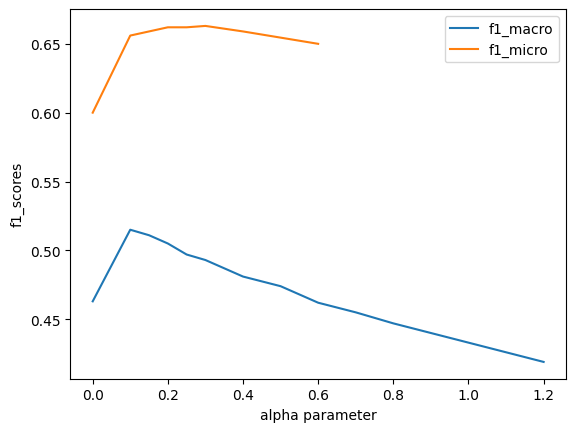

In [221]:
alpha_f1_macro = {'alpha': [0.0001, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.2], 
                'f1_macro': [0.463, 0.515, 0.511, 0.505, 0.497, 0.493, 0.481, 0.474, 0.462, 0.455, 0.447, 0.419]}
alpha_f1_micro = {'alpha': [0.0001, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.6], 
                'f1_micro': [0.600, 0.656, 0.659, 0.662, 0.662, 0.663, 0.659, 0.650]}

plt.plot(alpha_f1_macro['alpha'], alpha_f1_macro['f1_macro'], label='f1_macro')
plt.plot(alpha_f1_micro['alpha'], alpha_f1_micro['f1_micro'], label='f1_micro')

plt.xlabel('alpha parameter')
plt.ylabel('f1_scores')
plt.legend()
plt.show()

In [ ]:
best_alpha = 0.1
OVR_NB_pipeline = Pipeline([
                ('Vectorizer', CountVectorizer(stop_words='english')),
                ('MultiNB', OneVsRestClassifier(MultinomialNB(alpha=best_alpha) ))    ])

In [ ]:
# evaluating classification models

models = {"Logistic Regression": LogisticRegression(), 
          "KNN": KNeighborsClassifier(), 
          "DecisionTree": DecisionTreeClassifier(),
          "LinearSVC": LinearSVC()}

In [248]:
X_train.iloc[2]

'professor marvin h mills is a self published crank his book is printed by iuniverse a vanity publishing company mills also believes that the mosques in spain were built by phoenicians aided by survivors from atlantis we learn of the piri reis map that it lead ivar zapp and george erikson in atlantis in america to assert that an awareness of antartica was known to an advanced civilization at the end of the ice age and yes the published version of this book really does spell the second word of that sentence with an a mills is not a reliable source he is self published and his views are fringe'

## Resampling techniques

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

X_train = train_df['cleaner_text']
y = train_labels

X = CountVectorizer(stop_words='english').fit_transform(train_text)


In [34]:
fltr = train_df[train_df['identity_hate'] == 1] 
print(fltr.tail())


                                             comment_text  toxic  \
159281  LoL!! \n\nyou're GAY!! you will never know how...      1   
159336  Oh, fuck off. The pansy Jew would just whine a...      1   
159400  Shalom \n\nSemite, get the fuck out of here. I...      1   
159449                         I think he is a gay fag!!!      1   
159494  "\n\n our previous conversation \n\nyou fuckin...      1   

        severe_toxic  obscene  threat  insult  identity_hate  \
159281             1        1       0       1              1   
159336             0        1       0       1              1   
159400             1        1       1       1              1   
159449             0        0       0       0              1   
159494             0        1       0       1              1   

                                             cleaner_text  
159281         lol gay never know good feel fuck woman as  
159336  oh fuck pansy jew would whine bnai brith beat ...  
159400  shalom semite get 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, cross_validate

smote = SMOTE()
rus = RandomUnderSampler()

MultiNB = MultinomialNB() # NB takes ~10s to train all labels
LR = LogisticRegression()  # LR takes > 2 min to train all labels

cv_all = pd.DataFrame()

for label in LABELS:
    
    X_smote, y_smote = smote.fit_resample(X_train, y_train[label])
    X_rus, y_rus = rus.fit_resample(X_train, y_train[label])

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    score_evals = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'neg_log_loss']
    cv = cross_validate(MultiNB, X_rus, y_rus, cv=kf, scoring = score_evals, return_estimator=True)

    cv_df = pd.DataFrame(cv)
    cv_df.drop(['fit_time', 'score_time', 'estimator'], axis = 1, inplace = True) 
    
    print('Processing {} label'.format(label))
    display(cv_df)
    
    cv_mean = cv_df.mean()
    cv_all = pd.concat([cv_all, cv_mean], axis=1)

cv_all.columns = LABELS  # set the column names
cv_all.index = score_evals # set the index names

NameError: name 'NB' is not defined

In [ ]:
display(cv_all)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
accuracy,0.870377,0.933735,0.898608,0.905745,0.885564,0.896111
balanced_accuracy,0.870415,0.933776,0.898580,0.906563,0.885614,0.896211
precision,0.905824,0.929323,0.919712,0.897129,0.921038,0.908770
recall,0.826770,0.939017,0.873505,0.916965,0.843389,0.880695
f1,0.864450,0.934103,0.895991,0.906433,0.880408,0.894397
neg_log_loss,-0.837107,-0.434362,-0.773476,-0.540937,-0.808088,-0.628440


In [ ]:
cv_all.mean(axis=1)

accuracy             0.911811
balanced_accuracy    0.911623
precision            0.939029
recall               0.881478
f1                   0.909142
neg_log_loss        -0.280026
dtype: float64

In [ ]:
cv_all.to_csv('scores_LR_rus.csv')

In [ ]:
print(type(cv_df.mean()))

<class 'pandas.core.series.Series'>
Index(['test_balanced_accuracy', 'test_precision', 'test_recall', 'test_f1',
       'test_neg_log_loss'],
      dtype='object')


## Properly evaluate with testset

In [48]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, cross_validate
from sklearn.metrics import precision_recall_fscore_support

smote = SMOTE()
rus = RandomUnderSampler()

# model = MultinomialNB() # NB takes ~10s to train all labels
model = LogisticRegression()  # LR takes > 2 min to train all labels

label = 'obscene'

X_train, X_test, y_train, y_test = train_test_split(X, y[label], test_size=0.2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

def model_train_evaluate(model, X_train, y_train, X_test, y_test, dec=2, verbose=False):

    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    # print('Processing {} label'.format(label))
    # print(classification_report(y_test, pred, output_dict=False))
    bal_acc = np.round(balanced_accuracy_score(y_test, pred), dec)
    prec, rec, f1 = np.round(precision_recall_fscore_support(y_test, pred, average='binary', pos_label=1)[:3] , dec)
    CM = confusion_matrix(y_test, pred)
    TN, FN, TP, FP = CM[0][0], CM[1][0], CM[1][1], CM[0][1]
    if verbose:
        print('bal_acc: {}, precision: {}, recall: {}, f1: {}'.format(bal_acc, prec, rec, f1) )  
    
    return bal_acc, prec, rec, f1, TN, FN, TP, FP


In [49]:
def train_evaluate_all_labels(models, X, y, label='toxic', verbose=False):
    '''
    models: dict, for iterating through classifier models
    X, y: pd.DataFrame, array-like
    label: string that matches the columns of data
    verbose: bool, for optional print outs
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y[label], test_size=0.2) # Original split
    X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train) # Random Under Sampling (RUS)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train) #Synthetic Oversampling (SMOTE)
    
    n_0, n_1 = y_train.value_counts()
    imbalance_ratio = np.round(n_1/(n_0 + n_1), 3)
    
    train_sets = {'Original': [X_train, y_train], 
                    'RUS': [X_train_rus, y_train_rus], 
                    'SMOTE': [X_train_smote, y_train_smote]}
    
    scores = pd.DataFrame()  # initialize empty DF to store everything
    
    # iterate through the different training sets, must be in dictionary format
    for train_split, train_data in train_sets.items():  
        X_input, y_input = train_data
        
        # iterate through the classifier models, must be in dictionary format
        for model_name, model in models.items(): 
            
            bal_acc, prec, rec, f1, TN, FN, TP, FP = model_train_evaluate(model, X_input, y_input, X_test, y_test, verbose= verbose)
            scores = scores.append({'label': label,
                                    'imbalance_ratio': imbalance_ratio, 
                                    'clf_model': model_name,
                                    'train_split': train_split,
                                    'balanced_accuracy': bal_acc,
                                    'precision': prec,
                                    'recall': rec,
                                    'f1_score': f1,
                                    'TN': TN, 'FN': FN, 'TP': TP, 'FP': FP,}, ignore_index=True)
            
    return scores


In [50]:
%%time
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression


models = {'MultinomialNB': MultinomialNB(), 'LogisticRegression': LogisticRegression()}
all_scores= pd.DataFrame()
LABELS = ['toxic', 'obscene', 'insult', 'severe_toxic', 'identity_hate', 'threat']


for label in LABELS:
    scores = train_evaluate_all_labels(models, X, y, label=label, verbose=False)
    # print(scores)
    all_scores = pd.concat([all_scores, scores], axis=0)
    

C:\Users\Feng\AppData\Local\Temp\ipykernel_21424\3628545022.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({'label': label,
C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Feng\AppData\Local\Temp\ipykernel_21424\3628545022.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas

CPU times: total: 1min 16s
Wall time: 1min 18s


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Feng\AppData\Local\Temp\ipykernel_21424\3628545022.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({'label': label,


In [43]:
# display(all_scores)
display(all_scores.groupby(['label']).mean().sort_values(by='imbalance_ratio'))
display(all_scores.groupby(['clf_model']).mean())
display(all_scores.groupby(['train_split']).mean())


C:\Users\Feng\AppData\Local\Temp\ipykernel_21424\462376751.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(all_scores.groupby(['label']).mean().sort_values(by='imbalance_ratio'))


,imbalance_ratio,balanced_accuracy,precision,recall,f1_score
label,,,,,
threat,0.003,0.710000,0.111667,0.460000,0.118333
identity_hate,0.009,0.718333,0.161667,0.473333,0.173333
severe_toxic,0.010,0.791667,0.223333,0.615000,0.276667
insult,0.049,0.823333,0.496667,0.695000,0.546667
obscene,0.052,0.853333,0.575000,0.740000,0.625000
toxic,0.096,0.836667,0.615000,0.735000,0.650000


C:\Users\Feng\AppData\Local\Temp\ipykernel_21424\462376751.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(all_scores.groupby(['clf_model']).mean())


,imbalance_ratio,balanced_accuracy,precision,recall,f1_score
clf_model,,,,,
LogisticRegression,0.0365,0.797778,0.381111,0.641111,0.403889
MultinomialNB,0.0365,0.780000,0.346667,0.598333,0.392778


C:\Users\Feng\AppData\Local\Temp\ipykernel_21424\462376751.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(all_scores.groupby(['train_split']).mean())


,imbalance_ratio,balanced_accuracy,precision,recall,f1_score
train_split,,,,,
Original,0.0365,0.693333,0.506667,0.397500,0.4375
RUS,0.0365,0.897500,0.280833,0.865000,0.3850
SMOTE,0.0365,0.775833,0.304167,0.596667,0.3725


In [53]:
display(all_scores.sort_values(by='f1_score', ascending=False))

,label,imbalance_ratio,clf_model,train_split,balanced_accuracy,precision,recall,f1_score,TN,FN,TP,FP
1,obscene,0.053,LogisticRegression,Original,0.84,0.87,0.68,0.76,30078,534,1129,174
1,toxic,0.097,LogisticRegression,Original,0.82,0.83,0.65,0.73,28566,1047,1919,383
3,obscene,0.053,LogisticRegression,RUS,0.93,0.56,0.89,0.69,29098,176,1487,1154
3,toxic,0.097,LogisticRegression,RUS,0.90,0.53,0.87,0.66,26680,378,2588,2269
0,toxic,0.097,MultinomialNB,Original,0.79,0.71,0.61,0.66,28203,1143,1823,746
4,toxic,0.097,MultinomialNB,SMOTE,0.80,0.65,0.63,0.64,27928,1094,1872,1021
4,obscene,0.053,MultinomialNB,SMOTE,0.82,0.59,0.66,0.63,29487,558,1105,765
0,obscene,0.053,MultinomialNB,Original,0.79,0.64,0.59,0.62,29695,676,987,557
2,toxic,0.097,MultinomialNB,RUS,0.87,0.50,0.82,0.62,26514,541,2425,2435
1,insult,0.050,LogisticRegression,Original,0.75,0.76,0.51,0.61,30120,766,784,245


In [183]:
# trying different classifiers

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier



a
1
2
b
3
4


In [41]:
cm = confusion_matrix(pred, y_test)

tp, fp, tn, fn = cm[1,1], cm [1,0], cm[0,0], cm[0,1]  # 1's are true
tp, fp, tn, fn = cm[0,0], cm [0,1], cm[1,1], cm[1,0]  # 0's are true

prec = tp/(tp+fp)
print(prec)

0.9607903993378853
